<a href="https://colab.research.google.com/github/marianna718/Repo_1/blob/main/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [10]:

# %cd '/content/drive/MyDrive/task3/'
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
!ls
from lfw_datas import fetch_lfw_dataset
# import lfw_datas
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]


drive  lfw_datas.py  sample_data
images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%cd '/content/drive/MyDrive/task3/'

/content/drive/MyDrive/task3


In [ ]:

!pwd

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import numpy as np
# plt.rcParams.update({'axes.titlesize': 'small'})

# from sklearn.datasets import load_digits
# #The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# #Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# # from lfw_dataset import fetch_lfw_dataset
# from sklearn.datasets import fetch_lfw_people
# # data,attrs = fetch_lfw_people(dimx=36,dimy=36)
# lfw_people = fetch_lfw_people(resize=0.3)

# # introspect the images arrays to find the shapes (for plotting)
# n_samples, h, w = lfw_people.images.shape
# X = lfw_people.data #data
# n_features = X.shape[1]
# data = X

# y = lfw_people.target
# target_names = lfw_people.target_names #attrs
# n_classes = target_names.shape[0]
# attrs = target_names
# #preprocess faces
# data = np.float32(data)/255.

# IMG_SHAPE = data.shape[1:]

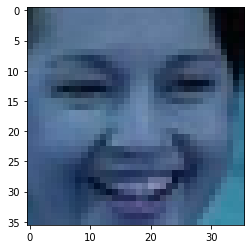

In [ ]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [75]:
CODE_SIZE = 256
def build_generator():
  generator = Sequential()
  generator.add(L.InputLayer([CODE_SIZE],name='noise'))
  generator.add(L.Dense(10*8*8, activation='elu'))

  generator.add(L.Reshape((8,8,10)))
  generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
  generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
  generator.add(L.UpSampling2D(size=(2,2)))
  generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
  generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
  generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

  generator.add(L.Conv2D(3,kernel_size=3,activation=None))
  # generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
  return generator

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [68]:
# discriminator = Sequential()

# discriminator.add(L.InputLayer(IMG_SHAPE))

  discriminator.add(L.InputLayer(IMG_SHAPE))
  discriminator.add(L.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU())
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU())
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU())
  discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU())
  discriminator.add(L.Flatten())
  discriminator.add(L.Dense(256))
  discriminator.add(L.LeakyReLU())
  discriminator.add(L.Dense(128))
  discriminator.add(L.LeakyReLU())
# # <build discriminator body>
# discriminator.add(L.Conv2D(64, kernel_size = 3, activation= 'relu'))
# discriminator.add(L.MaxPooling2D(2))
# discriminator.add(L.Conv2D(32, kernel_size = 3, activation= 'relu'))
# discriminator.add(L.MaxPooling2D(2))
# discriminator.add(L.Flatten())
# discriminator.add(L.Dense(256,activation='tanh'))
# discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
# discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)

IndentationError: ignored

In [76]:
def discriminator_build():
  discriminator = Sequential()

  discriminator.add(L.InputLayer(IMG_SHAPE))
  discriminator.add(L.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU(0.2))
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU(0.2))
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.LeakyReLU(0.2))
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.LeakyReLU(0.2))

  discriminator.add(L.Flatten())
  discriminator.add(L.Dropout(0.3))
  discriminator.add(L.Dense(256))
  discriminator.add(L.LeakyReLU(0.2))
  discriminator.add(L.Dense(128))
  discriminator.add(L.LeakyReLU(0.2))
  discriminator.add(L.Dense(1, activation='sigmoid'))
  return discriminator

In [77]:
generator = build_generator()
discriminator = discriminator_build()

In [78]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [16]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [37]:
dis_opt = tf.optimizers.SGD(0.0002 )
gen_opt = tf.optimizers.Adam(0.0002 )
g_loss = tf.keras.losses.BinaryCrossentropy()
d_loss = tf.keras.losses.BinaryCrossentropy()
# generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
# discriminator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)


In [ ]:
# Model =  Model()

In [79]:
from tensorflow.python.ops.gen_linalg_ops import batch_cholesky
class GAN(tf.keras.Model):
  def __init__(self, generator, discriminator , *args, **kwargs):
    super().__init__(*args, **kwargs)
    #create attributes for discriminator and generator
    self.generator = generator
    self.discriminator = discriminator
    

    
  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args,**kwargs)
    self.g_opt = g_opt 
    self.d_opt = d_opt 
    self.g_loss = g_loss
    self.d_loss = d_loss
  def train_step(self,batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((100,256)), training = False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:
      #Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

    #Create labels for relal and fakes imagesAdd some noise to the outputs
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis= 0)
    #fake label = 1 , real label = 0
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis = 0)

    # Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)
    #Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #
    with tf.GradientTape() as g_tape:
      #Generate some new images
      gen_images = self.generator(tf.random.normal((100, 256)) ,training = True)

      #Create the predicted labels
      predicted_labels = self.discriminator(gen_images , training = False)

      #Calculate loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)
      #here we take opposite of labels for generated images becouse we wanted to somehow reaword our generator for makeing good fakes 

    #Applky backpropogation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss" : total_d_loss, "g_loss" : total_g_loss}


In [80]:

my_GAN = GAN(generator, discriminator)

In [81]:
my_GAN.compile(gen_opt, dis_opt, g_loss, d_loss)

In [82]:
data.shape

(13143, 36, 36, 3)

In [86]:
hist = my_GAN.fit(data,batch_size = 64,epochs=200)

Epoch 1/200
206/206 [==============================] - 17s 80ms/step - d_loss: 0.7231 - g_loss: 6.2687e-04
Epoch 2/200
206/206 [==============================] - 16s 80ms/step - d_loss: 0.7382 - g_loss: 5.5094e-04
Epoch 3/200
206/206 [==============================] - 17s 81ms/step - d_loss: 0.7663 - g_loss: 5.5457e-04
Epoch 4/200
206/206 [==============================] - 17s 81ms/step - d_loss: 0.7678 - g_loss: 7.7409e-04
Epoch 5/200
206/206 [==============================] - 17s 81ms/step - d_loss: 0.8094 - g_loss: 8.6931e-04
Epoch 6/200
206/206 [==============================] - 17s 81ms/step - d_loss: 0.8333 - g_loss: 0.0011
Epoch 7/200
206/206 [==============================] - 17s 80ms/step - d_loss: 0.8689 - g_loss: 0.0068
Epoch 8/200
206/206 [==============================] - 16s 80ms/step - d_loss: 0.9247 - g_loss: 0.0021
Epoch 9/200
206/206 [==============================] - 16s 80ms/step - d_loss: 0.9117 - g_loss: 3.1551e-04
Epoch 10/200
206/206 [===========================

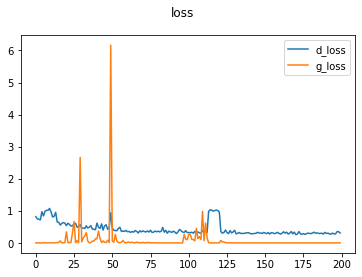

In [88]:
plt.suptitle('loss')
plt.plot(hist.history['d_loss'], label = 'd_loss')
plt.plot(hist.history['g_loss'], label = 'g_loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step


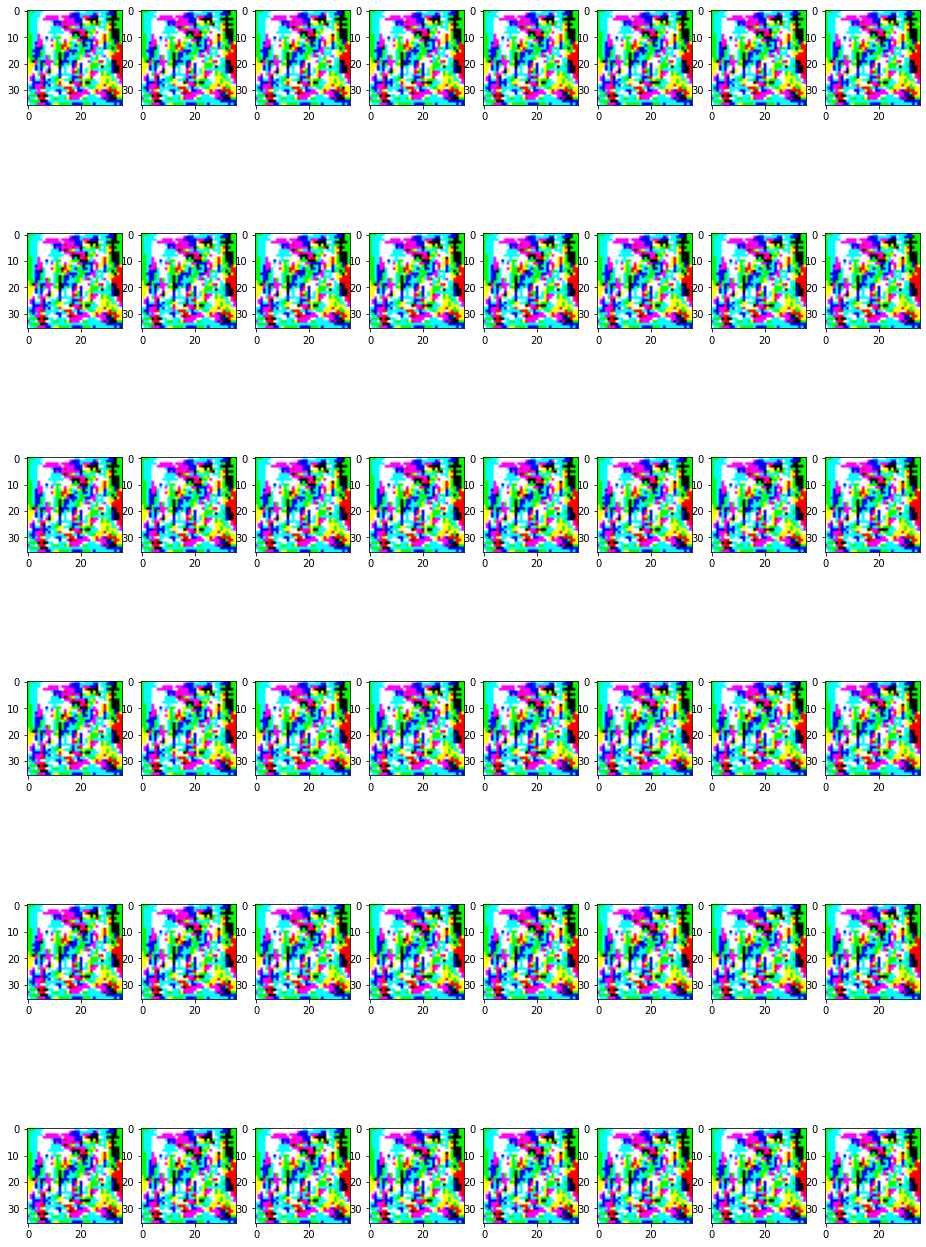

In [95]:
g = generator.predict(tf.random.normal((15,256)))
plt.figure(figsize=[16,24])
sample_images(6,8)

In [ ]:
 n# from IPython import display
# from tqdm import tnrange
# import math
# # loss_fn = tf.keras.losses.BinaryCrossentropy()
# with tf.GradientTape(persistent=True) as tape:
#   for epoch in tnrange(50000):
#     real_data = sample_data_batch(100)
#     noise = sample_noise_batch(100)
    

#     ########################
#     #discriminator training#
#     ########################
#     for i in range(5):
#       logp_real = discriminator(real_data)
      
      
#       generated_data = generator(noise) #<gen(noise)> 
      
#       logp_gen = np.log(1 - discriminator(generated_data))  #<log P(real | gen(noise))
#       print(logp_gen.shape)
#       print(logp_real.shape)
      
#       d_loss = -tf.reduce_mean(logp_real + logp_gen)
#         #regularize
#       d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
        
#       #optimize 
#       disc_optimizer.minimize(d_loss, var_list=discriminator.trainable_weights)
      
      
#     ########################
#     ###generator training###
#     ########################
    
#     g_loss = tf.reduce_mean(logp_gen[:, 0])   #<generator los>
#     #optimize
#     gen_optimizer.minimize(g_loss, var_list=generator.trainable_variables)

#     if epoch %100==0:
#       display.clear_output(wait=True)
#       sample_images(2,3,True)
#       sample_probas(1000)

      

4/4 [==============================] - 0s 4ms/step


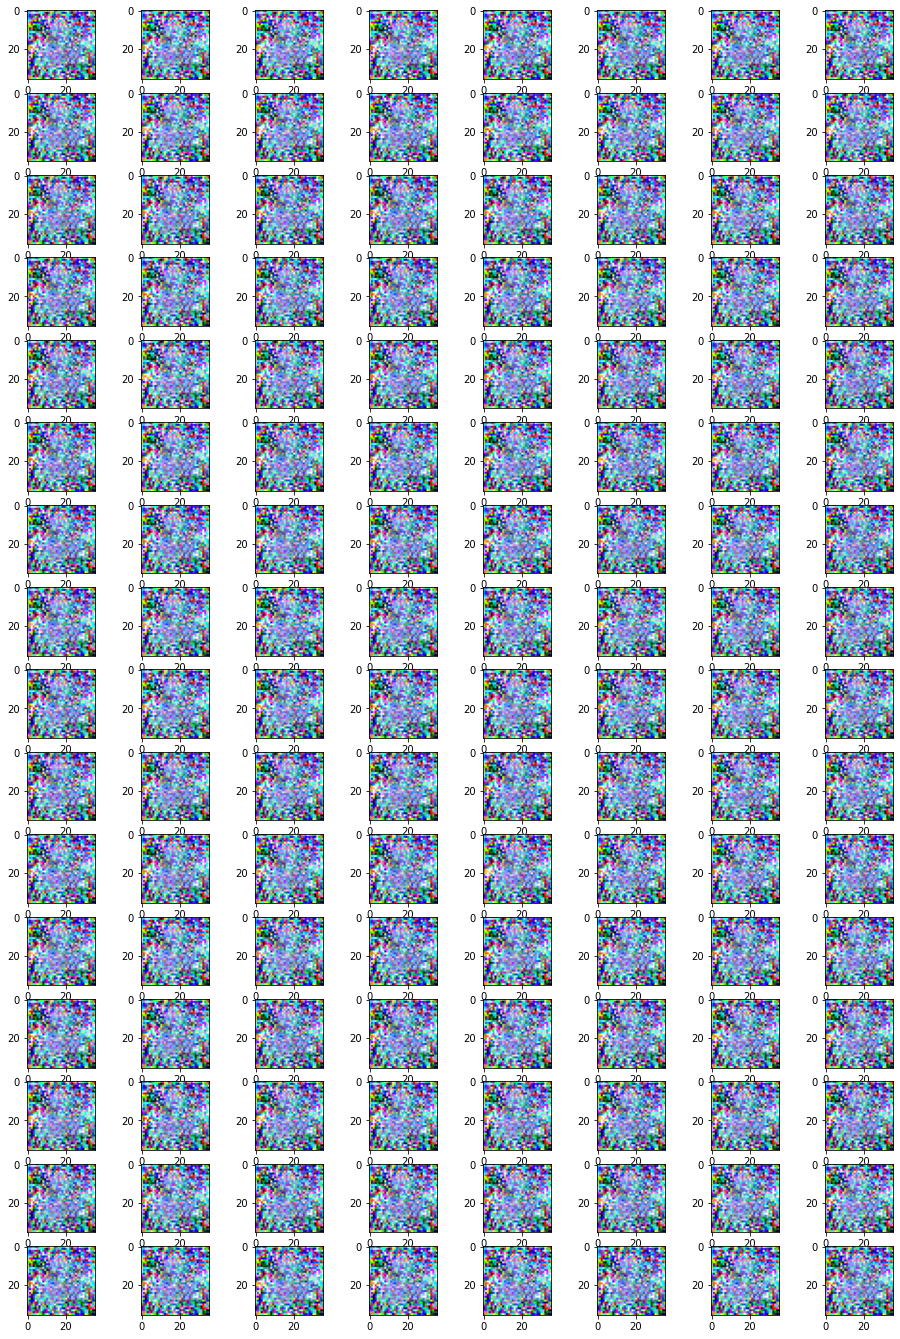

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)

In [ ]:
f